In [1]:
import numpy as np
import torch
from torchvision import transforms
import apex
import csv
import data
import models
import ast
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

### Data Loading

In [2]:
batch_size = 8

def parse_list(input_str):    
    return ast.literal_eval(input_str)

reports = {}

with open("./cleaned_reports.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            uid, problems, findings, impression = row[1:]
            reports[str(uid)] = (parse_list(problems), findings, impression)

def create_report_splits(reports, seed=1337):
    uid_list = list(reports.keys())
    train_uids, valtest_uids = train_test_split(uid_list, test_size=0.2, random_state=seed)
    valid_uids, test_uids = train_test_split(valtest_uids, test_size=0.5, random_state=seed)
    
    train_reports = {}
    valid_reports = {}
    test_reports = {}
    splits = [train_uids, valid_uids, test_uids]
    output_reports = [train_reports, valid_reports, test_reports]
    
    for i in range(len(splits)):
        for uid in splits[i]:
            output_reports[i][str(uid)] = reports[str(uid)]
            
    return output_reports

train_reports, valid_reports, _ = create_report_splits(reports)

train_dataset = data.XRayDataset(
    reports=train_reports,
    transform=transforms.Compose([
        transforms.Resize(2048),
        transforms.CenterCrop((2048,2048)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]
))
train_dataloader = torch.utils.data.dataloader.DataLoader(train_dataset,
                                                          collate_fn=data.collate_fn,
                                                          pin_memory=True,
                                                          shuffle=True,
                                                          batch_size=batch_size,
                                                          num_workers=batch_size)

valid_dataset = data.XRayDataset(
    reports=valid_reports,
    transform=transforms.Compose([
        transforms.Resize(2048),
        transforms.CenterCrop((2048,2048)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        ]
))
valid_dataloader = torch.utils.data.dataloader.DataLoader(valid_dataset,
                                                          collate_fn=data.collate_fn,
                                                          pin_memory=True,
                                                          shuffle=True,
                                                          batch_size=batch_size,
                                                          num_workers=batch_size)

### Build Model

In [3]:
embed_size = 128
hidden_size = 128
num_layers = 3
learning_rate = 0.001
memory_format = torch.channels_last
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = models.EncoderCNN(embed_size).to(device, memory_format=memory_format)
decoder = models.DecoderRNN(embed_size, hidden_size, len(train_dataset.vocab), num_layers).to(device)

criterion = torch.nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = apex.optimizers.FusedAdam(params, lr=learning_rate)

[encoder, decoder], optimizer = apex.amp.initialize([encoder, decoder], optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


### Train Model

In [4]:
num_epochs = 5
total_step = len(train_dataloader.dataset)//batch_size


print("Start training")

for epoch in range(num_epochs):
    print("\nEpoch", epoch+1, "/", num_epochs, ":\n")
    
    encoder.train()
    decoder.train()
    
    running_loss = torch.Tensor([0.0])
    
    for i, (images, captions, lengths) in enumerate(tqdm(train_dataloader, total=total_step)):
        images = images.cuda(non_blocking=True).contiguous(memory_format=memory_format)
        captions = captions.cuda(non_blocking=True).contiguous()
        targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]
        encoder.zero_grad()
        decoder.zero_grad()
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        with apex.amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = float(running_loss.item()/total_step)

    print("train_loss - ", train_loss, "- perplexity -", np.exp(train_loss))

Start training

Epoch 1 / 5 :




train_loss -  tensor(2.1492, device='cuda:0', grad_fn=<NllLossBackward>) - perplexity - 14.724846509134151

Epoch 2 / 5 :




train_loss -  tensor(1.1230, device='cuda:0', grad_fn=<NllLossBackward>) - perplexity - 4.501699653630798

Epoch 3 / 5 :




train_loss -  tensor(0.3035, device='cuda:0', grad_fn=<NllLossBackward>) - perplexity - 2.8806033896707848

Epoch 4 / 5 :




train_loss -  tensor(0.9934, device='cuda:0', grad_fn=<NllLossBackward>) - perplexity - 2.367973083921332

Epoch 5 / 5 :




train_loss -  tensor(1.0955, device='cuda:0', grad_fn=<NllLossBackward>) - perplexity - 2.1325770914552042


### Inference

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

encoder.eval()
decoder.eval()

DecoderRNN(
  (embed): Embedding(52, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True)
  (linear): Linear(in_features=128, out_features=52, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (layer_norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


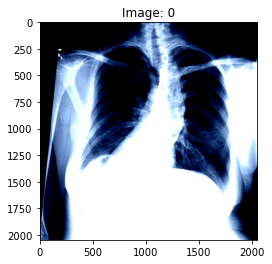

 Original: no acute changes from prior imaging.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


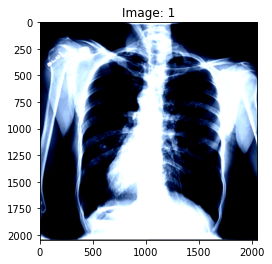

 Original: 1. no acute cardiopulmonary abnormality. 2. no suspicious masses or nodules.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


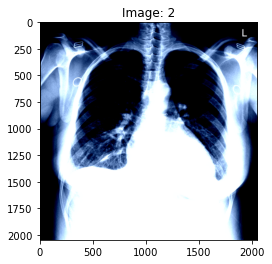

 Original: borderline cardiac enlargement. vascular congestion without overt pulmonary edema. basilar atelectasis with xxxx posterior recess pleural effusions. overall, findings of mild volume overload.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


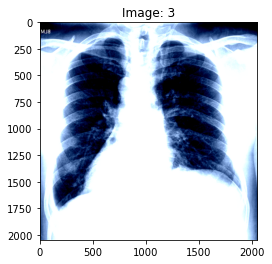

 Original: xxxx xxxx right pleural effusion.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


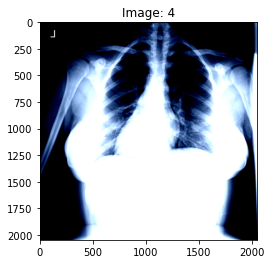

 Original: no acute cardiopulmonary abnormality identified.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


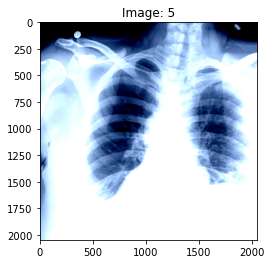

 Original: minimal atelectasis right base. no evidence of tuberculosis. heart size is normal.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


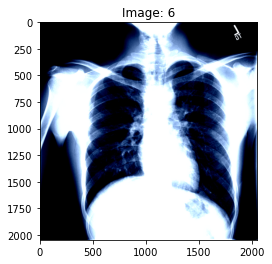

 Original: no acute cardiopulmonary disease.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


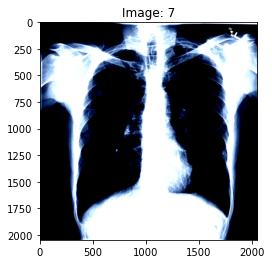

 Original: appearance suggests emphysema. apical capping, slightly greater at the left. recommend comparison with prior films or followup chest x-xxxx films to confirm stability and approximately 4 months in xxxx. critical result notification documented through primordial.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


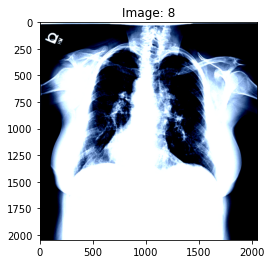

 Original: 1. continued hilar fullness consistent with adenopathy and bilateral interstitial opacities. stable as compared to earlier study. the changes are compatible with known diagnosis of sarcoidosis.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


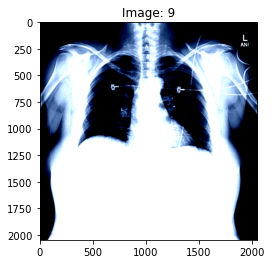

 Original: negative for acute abnormality.
Generated: no acute cardiopulmonary abnormality. stable chest xxxx of the l



In [6]:
for index in range(0, 10):
    image, impression = train_dataset.__getitem__(index)
    image_tensor = image.unsqueeze(0).cuda()
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = list(sampled_ids[0].cpu().numpy())

    plt.title("Image: "+str(index))
    plt_img = np.moveaxis(image.numpy(), 0, -1)
    plt.imshow(plt_img)
    plt.show()

    print(" Original:", train_dataset.tokenizer.decode(impression))
    print("Generated:", train_dataset.tokenizer.decode(sampled_ids))
    print("")